In [2]:
import emcee
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pyfits
import pandas as pd
import corner
import os
import utils as myUtils
from matplotlib.patches import Ellipse
from astropy.modeling.functional_models import Sersic2D
import multiprocessing as mp

from multiprocessing import Pool

path = r'G:\Mi unidad\Universidad\Master_Astro\TFM\ALMA_images\Original\\'
sources = os.listdir(path)[0:-1]
profile = 'C'

# names = ['AL-65.1', 'AL-57.1', 'AL115.1', 'AL74.1', 'AL71.1', 'AL70.1', 'AL49.1', 'AL19.1', 'AL11.1', 'AL-122.1',
#          'AL-116.2', 'AL-84.1', 'AL-80.1', 'AL-75.1', 'AL-66.1', 'LESS76', 'LESS73', 'LESS67', 'LESS45', 'LESS39',
#          'LESS29', 'LESS17', 'LESS15', 'LESS10', 'LESS9', 'LESS5', 'LESS3', 'LESS1', 'XID917', 'XID371',
#          'XID360', 'XID301', 'XID156', 'XID36', 'LESS112', 'LESS101']

#names = ['AL49.1','AL-65.1', 'AL115.1', 'AL71.1', 'AL11.1', 'AL-84.1','AL-75.1', 'LESS39',
#        'LESS15','LESS3','LESS76','XID360']

names = ['AL115.1']
if profile == 'A':
    data = pd.DataFrame(
        columns=['Source', 'SN', 'Relative RA [arcsec]', 'Relative RA low', 'Relative RA up',
        'Relative Dec [arcsec]', 'Relative Dec low', 'Relative Dec up', 'Effective radius [arcsec]',
        'Effective radius low', 'Effective radius up', 'Ellipticity', 'Ellipticity low',
        'Ellipticity up', 'Angle [deg]', 'Angle low', 'Angle up', 'Amplitude [mJy]', 'Amplitude low',
        'Amplitude up', 'Beam min [arcsec]', 'Beam maj [arcsec]', 'BIC', 'Flux [mJy]', 'Flux err'])

elif profile == 'B':
    data = pd.DataFrame(
        columns=['Source', 'SN', 'Relative RA [arcsec]', 'Relative RA low', 'Relative RA up',
        'Relative Dec [arcsec]', 'Relative Dec low', 'Relative Dec up', 'FWHM x [arcsec]',
        'FWHM x low', 'FWHM x up', 'FWHM y [arcsec]', 'FWHM y low', 'FWHM y up', 'Angle G [deg]',
        'Angle G low', 'Angle G up', 'Amplitude G [mJy]', 'Amplitude G low', 'Amplitude G up',
        'Beam min [arcsec]', 'Beam maj [arcsec]', 'BIC', 'Flux [mJy]', 'Flux err'])
    
elif profile == 'C':
    
    data = pd.DataFrame(columns=['Source','SN','Relative RA [arcsec]', 'Relative RA low', 'Relative RA up',
                  'Relative Dec [arcsec]','Relative Dec low','Relative Dec up','FWHM x [arcsec]',
                  'FWHM x low','FWHM x up','FWHM y [arcsec]','FWHM y low',
                  'FWHM y up','Angle G [deg]','Angle G low','Angle G up',
                  'Amplitude G [mJy]','Amplitude G low','Amplitude G up',
                  'Amplitude S [mJy]','Amplitude S low','Amplitude S up',
                  'Angle S [deg]','Angle S low','Angle S up',
                  'Effective radius [arcsec]','Effective radius low','Effective radius up',
                  'Ellipticity','Ellipticity low','Ellipticity up',                  
                  'Beam min [arcsec]', 'Beam maj [arcsec]', 'BIC', 'Flux [mJy]', 'Flux err'])

for i in range(0, len(names)):
    print('Fitting ' + names[i] + '....')

    fits_file = pyfits.open(path + sources[i])

    if sources[i] == 'cont_clean_AL-75.1_plot_briggs.fits':
        image_data = fits_file[0].data
    else:
        image_data = fits_file[0].data[0][0]

    flux = myUtils.zoom(image_data, 34)
    x_center = flux.shape[0] / 2
    y_center = flux.shape[1] / 2
    ra_center = fits_file[0].header['CRVAL1']
    dec_center = fits_file[0].header['CRVAL2']
    dx = fits_file[0].header['CDELT1']
    dy = fits_file[0].header['CDELT2']
    bmaj = fits_file[0].header['BMAJ']  # convert from degrees to arcsec
    bmin = fits_file[0].header['BMIN']
    bpa = fits_file[0].header['BPA']

    flux = flux * 10 ** 3 * ( (4 * np.log(2) / (np.pi * bmaj * bmin/(dx**2))) ) # units: [mJY] It isn't a density


    x_extent = (np.array([0., flux.shape[1]]) - (flux.shape[1] - x_center + 0.5)) * dx * 3600 * (
        -1)  # half pixel to center the map
    y_extent = (np.array([0., flux.shape[0]]) - (flux.shape[0] - y_center + 0.5)) * dy * 3600
    extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]

    x_grid = np.linspace(x_extent[0], x_extent[1], flux.shape[1])
    y_grid = np.linspace(y_extent[0], y_extent[1], flux.shape[0])
    x_grid, y_grid = np.meshgrid(x_grid, y_grid)
    sn = myUtils.s_n(flux)
    bmin_s = np.abs(bmin * 3600) / (2 * np.sqrt(2 * np.log(2)))  # unidades de sigma
    bmaj_s = np.abs(bmaj * 3600) / (2 * np.sqrt(2 * np.log(2)))

    ### Fitting with curve fit ###
    popt, pcov = myUtils.get_parameter_curve_fit(flux, x_grid, y_grid, profile=profile, beam=[bmin_s, bmaj_s])

    if profile == 'A':
        amplitude_sersic, r_eff, x_0, y_0, ellip, angle_sersic = popt  # sersic
        pos = [amplitude_sersic, r_eff, x_0, y_0, ellip, angle_sersic]
        labels = ['amplitude_sersic', 'r_eff', 'x_0', 'y_0', 'ellip', 'angle_sersic']

    elif profile == 'B':
        x_0, y_0, sigma_y, sigmax_minus_y, amplitude, theta = popt  # gaussian
        sigma_x = sigma_y + np.abs(sigmax_minus_y)
        pos = [amplitude, x_0, y_0, sigma_x, sigma_y, theta]
        labels = ['amplitude', 'x_0', 'y_0', 'sigma_x', 'sigma_y', 'theta']

    elif profile == 'C':
        x_0, y_0, sigma_y, sigmax_minus_y, amplitude, theta, amplitude_sersic, r_eff, ellip, angle_sersic = popt
        sigma_x = sigma_y + np.abs(sigmax_minus_y)
        pos = [amplitude, x_0, y_0, sigma_x, sigma_y, theta, amplitude_sersic, r_eff, ellip, angle_sersic]
        labels = ['amplitude', 'x_0', 'y_0', 'sigma_x', 'sigma_y', 'theta', 'amplitude_sersic', 'r_eff', 'ellip',
                  'angle_sersic']

    ### Fitting with emcee ###
    ndim, nwalkers = len(pos), 600
    pos = [np.abs(np.random.normal(pos, 0.01)) for l in range(nwalkers)]  # initialing araund a normal

    with Pool() as pool:
    
        sampler = emcee.EnsembleSampler(nwalkers, ndim, myUtils.log_probability, 
                                args=[x_grid.ravel(), y_grid.ravel(), flux.ravel(),
                                      myUtils.std_image(flux), [],
                                      bmin_s,bmaj_s,bpa,profile],
                                pool=pool)#, blobs_dtype=dtype)

        print("Running production...")
        sampler.run_mcmc(pos, 4000, progress=True);

    print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

    fig, axes = plt.subplots(len(labels), figsize=(11, 20), sharex=True)
    samples = sampler.get_chain()
    for j in range(len(labels)):
        ax = axes[j]
        ax.plot(samples[:, :, j], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[j])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    del (samples)
    #plt.savefig('chains_' + str(names[i]) + '.jpg')
    plt.close(fig)

    flat_samples = sampler.get_chain(discard=500, thin=10, flat=True)
    fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True)
    #plt.savefig('coner_Plot_' + str(names[i]) + '.png')
    plt.close(fig)

    parameters_fit_50 = []
    upper_limits = []
    low_limits = []
    # hdp = [] # highest posterior density (HPD) of array for given alpha 0.05
    for j in range(ndim):
        mcmc = np.percentile(flat_samples[500:, j], [16, 50, 84])
        q = np.diff(mcmc)
        # hpd_, _, _, _ = myUtils.hpd_grid(flat_samples[100:, j])
        parameters_fit_50.append(mcmc[1])
        low_limits.append(q[0])
        upper_limits.append(q[1])

    # hdp.append(hpd_)
    # hdp = np.asarray(hdp)
    del (flat_samples)

    for n, j in enumerate(labels):
        print(j + ':', parameters_fit_50[n])

    #### Maps

    flux2 = myUtils.zoom(image_data, 50) * 10 ** 3 * ( (4 * np.log(2) / (np.pi * bmaj * bmin/(dx**2))) )
    x_center2 = flux2.shape[0] / 2
    y_center2 = flux2.shape[1] / 2
    x_extent2 = (np.array([0., flux2.shape[1]]) - (flux2.shape[1] - x_center2 + 0.5)) * dx * 3600 * (
        -1)  # half pixel to center the map
    y_extent2 = (np.array([0., flux2.shape[0]]) - (flux2.shape[0] - y_center2 + 0.5)) * dy * 3600
    extent2 = [x_extent2[0], x_extent2[1], y_extent2[0], y_extent2[1]]

    x_grid2 = np.linspace(x_extent2[0], x_extent2[1], flux2.shape[1])
    y_grid2 = np.linspace(y_extent2[0], y_extent2[1], flux2.shape[0])
    x_grid2, y_grid2 = np.meshgrid(x_grid2, y_grid2)

    plt.rcParams.update({'font.size': 16})
    plt.rcParams.update({'xtick.labelsize': 16})
    plt.rcParams.update({'ytick.labelsize': 16})
    plt.rcParams.update({'axes.linewidth': 2})
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(10.5, 5))

    plt1 = ax[0].imshow(flux2, cmap='YlOrRd', origin='lower', extent=extent2, vmin=flux2.min(), vmax=flux2.max())

    rms = myUtils.std_image(flux2)

    levels = [-2 * rms, 2 * rms, 4 * rms, 6 * rms, 10 * rms, 15 * rms, 20 * rms]
    plt2 = ax[0].contour(flux2, levels, colors='k', alpha=0.8, linewidths=1.0, extent=extent2)
    ax[0].set_xlabel('Relative RA [arcsec]')
    ax[0].set_ylabel('Relative Dec [arcsec]')

    # plot the best fit ellipse emcee
    if profile == 'A':
        amplitude_sersic_emcee, r_eff_emcee, x_0_emcee, y_0_emcee, ellip_emcee, angle_sersic_emcee = parameters_fit_50
        amplitude_sersic_emcee_up, r_eff_emcee_up, x_0_emcee_up, y_0_emcee_up, ellip_emcee_up, angle_sersic_emcee_up = upper_limits
        amplitude_sersic_emcee_low, r_eff_emcee_low, x_0_emcee_low, y_0_emcee_low, ellip_emcee_low, angle_sersic_emcee_low = low_limits
        ax[0].scatter(x_0_emcee, y_0_emcee, marker="x", s=20)

        a, b = r_eff_emcee, (1 - ellip_emcee) * r_eff_emcee
        pa_deg_emcee = 180 - angle_sersic

        fit_ellipse_emcee_ser = Ellipse((x_0_emcee, y_0_emcee), width=a*2, height=b*2, angle=pa_deg_emcee, facecolor='none', edgecolor='green', alpha=1.0, lw=2, zorder=200)

        ax[0].add_artist(fit_ellipse_emcee_ser)
        mod = Sersic2D(amplitude=amplitude_sersic_emcee, r_eff=r_eff_emcee, n=1, x_0=x_0_emcee, y_0=y_0_emcee, ellip=ellip_emcee, theta=np.radians(180 - angle_sersic))
        fobs2 = mod(x_grid2, y_grid2)

    elif profile == 'B':
        amplitude_emcee, x_0_emcee, y_0_emcee, sigma_x_emcee, sigma_y_emcee, angle_emcee = parameters_fit_50
        amplitude_emcee_up, x_0_emcee_up, y_0_emcee_up, sigma_x_emcee_up, sigma_y_emcee_up, angle_emcee_up = upper_limits
        amplitude_emcee_low, x_0_emcee_low, y_0_emcee_low, sigma_x_emcee_low, sigma_y_emcee_low, angle_emcee_low = low_limits
        ax[0].scatter(x_0_emcee, y_0_emcee, marker="x", s=20)

        FWHM_x_emcee = 2 * np.sqrt(2 * np.log(2)) * sigma_x_emcee
        FWHM_y_emcee = 2 * np.sqrt(2 * np.log(2)) * sigma_y_emcee
        pa_deg_emcee = 180 - angle_emcee
        fit_ellipse_emcee_gauss = Ellipse((x_0_emcee, y_0_emcee), width=0.5 * FWHM_x_emcee * 2, height=0.5 * FWHM_y_emcee *2,
                                          angle=pa_deg_emcee, facecolor='none', edgecolor='blue', alpha=1.0, lw=1,
                                          zorder=200)
        ax[0].add_artist(fit_ellipse_emcee_gauss)
        Gauss = myUtils.model_twoD_Gaussian([amplitude_emcee, x_0_emcee, y_0_emcee, sigma_x_emcee, sigma_y_emcee, angle_emcee],
            x_grid2, y_grid2).reshape(50, 50)
        fobs2 = Gauss

    if profile == 'C':
        amplitude_emcee, x_0_emcee, y_0_emcee, sigma_x_emcee, sigma_y_emcee, angle_emcee, amplitude_sersic_emcee, r_eff_emcee, ellip_emcee, angle_sersic_emcee = parameters_fit_50
        amplitude_emcee_up, x_0_emcee_up, y_0_emcee_up, sigma_x_emcee_up, sigma_y_emcee_up, angle_emcee_up, amplitude_sersic_emcee_up, r_eff_emcee_up, ellip_emcee_up, angle_sersic_emcee_up = upper_limits
        amplitude_emcee_low, x_0_emcee_low, y_0_emcee_low, sigma_x_emcee_low, sigma_y_emcee_low, angle_emcee_low, amplitude_sersic_emcee_low, r_eff_emcee_low, ellip_emcee_low, angle_sersic_emcee_low = low_limits
        ax[0].scatter(x_0_emcee, y_0_emcee, marker="x", s=20)

        FWHM_x_emcee = 2 * np.sqrt(2 * np.log(2)) * sigma_x_emcee
        FWHM_y_emcee = 2 * np.sqrt(2 * np.log(2)) * sigma_y_emcee
        pa_deg_emcee = 180 - angle_emcee
        fit_ellipse_emcee_gauss = Ellipse((x_0_emcee, y_0_emcee), width=0.5 * FWHM_x_emcee*2, height=0.5 * FWHM_y_emcee*2,
                                          angle=pa_deg_emcee, facecolor='none', edgecolor='blue', alpha=1.0, lw=1,
                                          zorder=200)
        ax[0].add_artist(fit_ellipse_emcee_gauss)
        Gauss = myUtils.model_twoD_Gaussian([amplitude_emcee, x_0_emcee, y_0_emcee, sigma_x_emcee, sigma_y_emcee, angle_emcee],
            x_grid2, y_grid2).reshape(50, 50)

        a, b = r_eff_emcee, (1 - ellip_emcee) * r_eff_emcee
        pa_deg_emcee = 180 - angle_sersic_emcee

        fit_ellipse_emcee_ser = Ellipse((x_0_emcee, y_0_emcee), width=a*2, height=b*2,
                                        angle=pa_deg_emcee, facecolor='none', edgecolor='green', alpha=1.0, lw=2,
                                        zorder=200)

        ax[0].add_artist(fit_ellipse_emcee_ser)
        mod = Sersic2D(amplitude=amplitude_sersic_emcee, r_eff=r_eff_emcee, n=1, x_0=x_0_emcee, y_0=y_0_emcee, ellip=ellip_emcee, theta=np.radians(180 - angle_sersic_emcee))
        Sersic = mod(x_grid2, y_grid2)

        fobs2 = Sersic + Gauss

        ax[0].legend(handles=[fit_ellipse_emcee_gauss, fit_ellipse_emcee_ser],
                     labels=['Gaussian ellipse', 'Sersic ellipse'], fontsize=10)


    ax[0].set_title(str(names[i]) + ' S/N: ' + str(round(sn)))
    # add beam of the observation
    pa = bpa + 90
    bmaj = fits_file[0].header['BMAJ'] * 3600  # convert from degrees to arcsec en unidades de fwhm
    bmin = fits_file[0].header['BMIN'] * 3600
    beam = Ellipse((x_extent2[0] + bmaj, y_extent2[0] + bmin), width=bmaj * 0.5 * 2, height=bmin * 0.5 * 2, angle=pa, facecolor='grey', edgecolor='grey', alpha=1.0, zorder=100)
    ax[0].add_artist(beam)

    plt3 = ax[1].imshow((flux2 - fobs2), cmap='YlOrRd', origin='lower', extent=extent2, vmin=flux2.min(),
                        vmax=flux2.max())
    ax[1].tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False)
    rms2 = myUtils.std_image((flux2 - fobs2))
    levels = [-8 * rms2, -6 * rms2, -4 * rms2, -2 * rms2, 2 * rms2, 4 * rms2, 6 * rms2, 8 * rms2]

    plt4 = ax[1].contour((flux2 - fobs2), levels, colors='k', alpha=0.8, linewidths=1.0, extent=extent2)
    ax[1].set_xlabel('Relative RA [arcsec]')
    ax[1].set_title('Residual map', fontsize=14)
    ax[1].scatter(x_0_emcee, y_0_emcee, marker="x", s=20)
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0.35)
    cbar = fig.colorbar(plt3, ax=ax.ravel().tolist(), shrink=0.75, pad=0.01)
    cbar.set_label(r'Flux density [$m$Jy]')

    # plt.savefig('map_fit_' + str(names[i]) + '_' + profile + '.jpg', dpi=250)
    plt.close(fig)

    integr, integral_noise = myUtils.Tflux(parameters_fit_50, dx,profile,rms=myUtils.std_image(flux))

    ### Save data to table ###
    if profile == 'A':

        data = data.append({'Source': names[i],
                            'SN': sn,
                            'Relative RA [arcsec]': x_0_emcee,
                            'Relative RA low': x_0_emcee_low,
                            'Relative RA up': x_0_emcee_up,
                            'Relative Dec [arcsec]': y_0_emcee,
                            'Relative Dec low': y_0_emcee_low,
                            'Relative Dec up': y_0_emcee_up,
                            'Effective radius [arcsec]': r_eff_emcee,
                            'Effective radius low': r_eff_emcee_low,
                            'Effective radius up ': r_eff_emcee_up,
                            'Ellipticity': ellip_emcee,
                            'Ellipticity low': ellip_emcee_low,
                            'Ellipticity up': ellip_emcee_up,
                            'Angle [deg]': angle_sersic_emcee,
                            'Angle low': angle_sersic_emcee_low,
                            'Angle up': angle_sersic_emcee_up,
                            'Amplitude [mJy]': amplitude_sersic_emcee,
                            'Amplitude low': amplitude_sersic_emcee_low,
                            'Amplitude up': amplitude_sersic_emcee_up,
                            'Beam min [arcsec]': fits_file[0].header['BMIN'] * 3600,
                            'Beam maj [arcsec]': fits_file[0].header['BMAJ'] * 3600,
                            'BIC': myUtils.bic(parameters_fit_50, x_grid, y_grid, flux, 'A'),
                            'Flux [mJy]':integr,
                            'Flux err':integral_noise}, ignore_index=True)

    elif profile == 'B':

        data = data.append({'Source': names[i],
                            'SN': sn,
                            'Relative RA [arcsec]': x_0_emcee,
                            'Relative RA low': x_0_emcee_low,
                            'Relative RA up': x_0_emcee_up,
                            'Relative Dec [arcsec]': y_0_emcee,
                            'Relative Dec low': y_0_emcee_low,
                            'Relative Dec up': y_0_emcee_up,
                            'FWHM x [arcsec]': FWHM_x_emcee,
                            'FWHM x low': 2 * np.sqrt(2 * np.log(2)) * sigma_x_emcee_low,
                            'FWHM x up': 2 * np.sqrt(2 * np.log(2)) * sigma_x_emcee_up,
                            'FWHM y [arcsec]': FWHM_y_emcee,
                            'FWHM y low': 2 * np.sqrt(2 * np.log(2)) * sigma_y_emcee_low,
                            'FWHM y up': 2 * np.sqrt(2 * np.log(2)) * sigma_y_emcee_up,
                            'Angle G [deg]': angle_emcee,
                            'Angle G low': angle_emcee_low,
                            'Angle G up': angle_emcee_up,
                            'Amplitude G [mJy]': amplitude_emcee,
                            'Amplitude G low': amplitude_emcee_low,
                            'Amplitude G up': amplitude_emcee_up,
                            'Beam min [arcsec]': fits_file[0].header['BMIN'] * 3600,
                            'Beam maj [arcsec]': fits_file[0].header['BMAJ'] * 3600,
                            'BIC': myUtils.bic(parameters_fit_50, x_grid, y_grid, flux, 'B'),
                            'Flux [mJy]':integr,
                            'Flux err':integral_noise}, ignore_index=True)
        print('end')

    elif profile == 'C':
        
        
        data = data.append({'Source': names[i],
                        'SN': sn,
                        'Relative RA [arcsec]': x_0_emcee,
                        'Relative RA low': x_0_emcee_low,
                        'Relative RA up': x_0_emcee_up,
                        'Relative Dec [arcsec]': y_0_emcee,
                        'Relative Dec low': y_0_emcee_low,
                        'Relative Dec up': y_0_emcee_up,
                        'FWHM x [arcsec]': FWHM_x_emcee,
                        'FWHM x low': 2 * np.sqrt(2 * np.log(2)) * sigma_x_emcee_low,
                        'FWHM x up': 2 * np.sqrt(2 * np.log(2)) * sigma_x_emcee_up,
                        'FWHM y [arcsec]': FWHM_y_emcee,
                        'FWHM y low': 2 * np.sqrt(2 * np.log(2)) * sigma_y_emcee_low,
                        'FWHM y up': 2 * np.sqrt(2 * np.log(2)) * sigma_y_emcee_up,
                        'Angle G [deg]': angle_emcee,
                        'Angle G low': angle_emcee_low,
                        'Angle G up': angle_emcee_up,
                        'Amplitude G [mJy]': amplitude_emcee,
                        'Amplitude G low': amplitude_emcee_low,
                        'Amplitude G up': amplitude_emcee_up,
                        'Amplitude S [mJy]': amplitude_sersic_emcee,
                        'Amplitude S low': amplitude_sersic_emcee_low,
                        'Amplitude S up': amplitude_sersic_emcee_up,
                        'Angle S [deg]': angle_sersic_emcee,
                        'Angle S low': angle_sersic_emcee_low,
                        'Angle S up': angle_sersic_emcee_up,
                        'Effective radius [arcsec]': r_eff_emcee,
                        'Effective radius low': r_eff_emcee_low,
                        'Effective radius up': r_eff_emcee_up,
                        'Ellipticity': ellip_emcee,
                        'Ellipticity low': ellip_emcee_low,
                        'Ellipticity up': ellip_emcee_up,
                        'Beam min [arcsec]':fits_file[0].header['BMIN'] * 3600,
                        'Beam maj [arcsec]':fits_file[0].header['BMAJ'] * 3600,
                        'BIC':myUtils.bic(parameters_fit_50, x_grid, y_grid, flux, profile),
                        'Flux [mJy]':integr,
                        'Flux err':integral_noise              
                        }, ignore_index=True)

# data.to_csv('data_fit_sersic.csv', index=False, sep=',')


Fitting AL115.1....
Running production...


  0%|                                                                                         | 0/4000 [00:00<?, ?it/s]C:\Users\agzal\.conda\envs\TEA\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [09:36<00:00,  6.94it/s]


Mean acceptance fraction: 0.087


amplitude: 74.88865924725081
x_0: 0.011355393167083505
y_0: 0.0012630645814052082
sigma_x: 0.018806005306339434
sigma_y: 0.0006362165872121844
theta: 92.97061583721646
amplitude_sersic: 0.011523307154546551
r_eff: 0.13454462631926428
ellip: 0.14704880029475356
angle_sersic: 113.21097831377296


TypeError: log_likelihood() missing 3 required positional arguments: 'bmaj', 'bpa', and 'profile'

In [3]:
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
amplitude, x_0, y_0, sigma_x, sigma_y, angle, amplitude_sersic, r_eff, ellip, angle_sersic = parameters_fit_50
theta1 = [amplitude, x_0, y_0, sigma_x, sigma_y, angle]
theta2 = [amplitude_sersic, r_eff, x_0, y_0, ellip, angle_sersic]
gauss_point = myUtils.model_twoD_Gaussian(theta1, x_grid, y_grid).reshape(34,34)
beam_gauss_kernel = Gaussian2DKernel(bmaj,bmin,theta=np.radians(bpa-90))
astropy_conv = convolve(gauss_point, beam_gauss_kernel)

model = astropy_conv.ravel() + myUtils.model_Sersic(theta2, x_grid, y_grid)

In [4]:
bmaj

0.127690181136144

In [5]:
sigma_x

0.018806005306339434

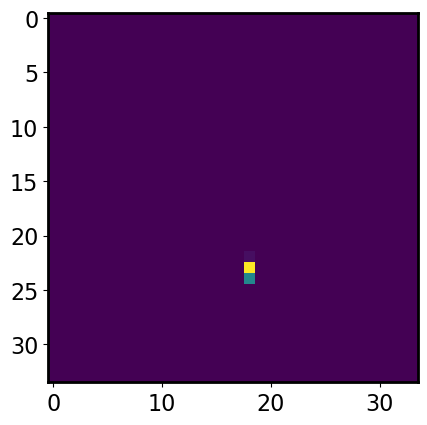

In [11]:
plt.imshow(astropy_conv)

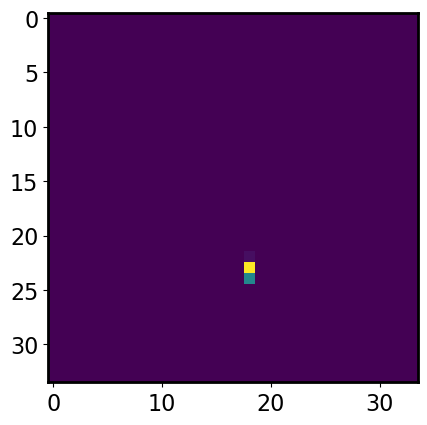

In [12]:
plt.imshow(gauss_point)

In [ ]:
pd.options.display.max_columns = None

data

In [13]:
data.to_csv('data_fit_sersic.csv', index=False, sep=',')


In [12]:
parameters_fit_50

[481.74917389253886,
 0.008559985216813441,
 0.001912692736525125,
 0.02956425192537797,
 0.00027845300329502616,
 179.6810685468938,
 0.007666077030692147,
 0.12284149997131896,
 0.13239768154767684,
 174.29474071043066]

In [24]:
bmaj = fits_file[0].header['BMAJ'] * 3600  # convert from degrees to arcsec en unidades de fwhm
bmin = fits_file[0].header['BMIN'] * 3600

In [45]:
bpa = fits_file[0].header['BPA']
bpa

-81.20117950439

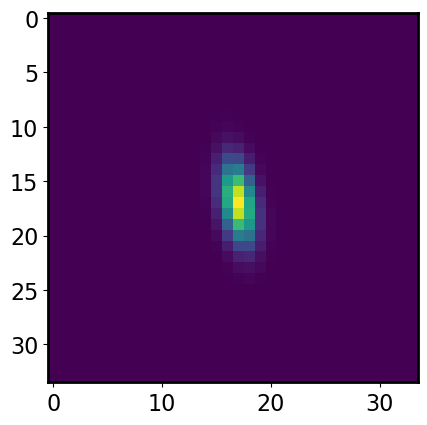

In [46]:
x_extent = (np.array([0., flux.shape[1]]) - (flux.shape[1] - x_center + 0.5)) * dx * 3600 * (-1)  # half pixel to center the map
y_extent = (np.array([0., flux.shape[0]]) - (flux.shape[0] - y_center + 0.5)) * dy * 3600
extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]

x_grid = np.linspace(x_extent[0], x_extent[1], flux.shape[1])
y_grid = np.linspace(y_extent[0], y_extent[1], flux.shape[0])
x_grid, y_grid = np.meshgrid(x_grid, y_grid)

Gauss = myUtils.model_twoD_Gaussian([.5, 0, 0, 0.05, 0.02, bpa], x_grid, y_grid).reshape(34,34)
plt1 = plt.imshow(Gauss.reshape(34,34), cmap='YlOrRd', origin='lower', extent=extent, vmin=Gauss.min(), vmax=Gauss.max())
fig.colorbar(ax=ax, mappable=plt1, orientation='vertical')
plt.imshow(Gauss)

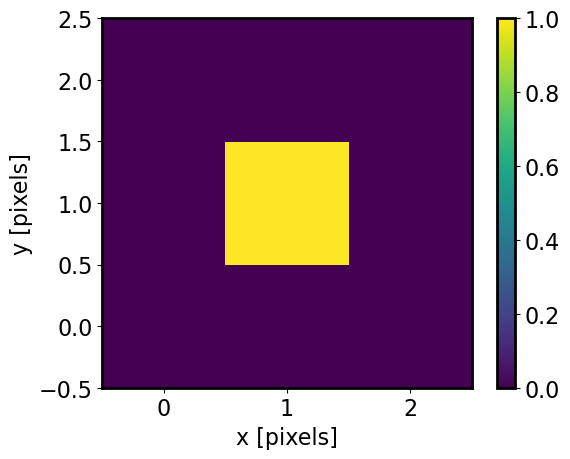

In [28]:
from astropy.convolution import convolve, Gaussian2DKernel
gaussian_2D_kernel = Gaussian2DKernel(bmaj,bmin)
plt.imshow(gaussian_2D_kernel, interpolation='none', origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()